<a href="https://colab.research.google.com/github/rshika/ashikaa-Ganesan/blob/master/opencv_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Installing needed libraries

# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!wget -q https://github.com/creotiv/computer_vision/raw/master/resources.tar.gz -O resources.tar.gz
!tar xzf resources.tar.gz
!ls -la

     |████████████████████████████████| 26.6MB 1.2MB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
total 796
drwxr-xr-x 1 root root   4096 Jun  7 09:35 .
drwxr-xr-x 1 root root   4096 Jun  7 09:33 ..
drwxr-xr-x 1 root root   4096 May 31 16:17 .config
drwxrwxr-x 5 1000 1000   4096 Mar 13  2018 resources
-rw-r--r-- 1 root root 791714 Jun  7 09:35 resources.tar.gz
drwxr-xr-x 1 root root   4096 May 31 16:17 sample_data


In [0]:
import cv2
import numpy as np
import scipy
from scipy.misc import imread
import cPickle as pickle
import random
import os
import matplotlib.pyplot as plt

In [0]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imread(image_path, mode="RGB")
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print 'Error: ', e
        return None

    return dsc


def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print 'Extracting features from image %s' % f
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'w') as fp:
        pickle.dump(result, fp)

In [0]:
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path) as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.iteritems():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

Extracting features from image resources/images/bicycle-1.jpg


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Extracting features from image resources/images/car-1.jpg
Extracting features from image resources/images/car-2.jpg
Extracting features from image resources/images/field-1.jpg
Extracting features from image resources/images/field-2.jpg
Extracting features from image resources/images/football-1.jpg
Extracting features from image resources/images/football-2.jpg
Extracting features from image resources/images/moto-1.jpg
Extracting features from image resources/images/moto-2.jpg
Extracting features from image resources/images/ocean-1.jpg
Extracting features from image resources/images/ocean-2.jpg
Extracting features from image resources/images/road-1.jpg
Extracting features from image resources/images/road-2.jpg
Extracting features from image resources/images/surfing-1.jpg
Extracting features from image resources/images/surfing-2.jpg
Query image ==========================================


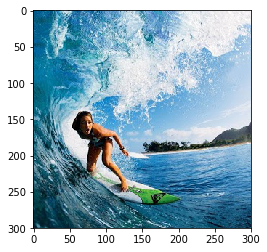

Result images ========================================
Match 1.0


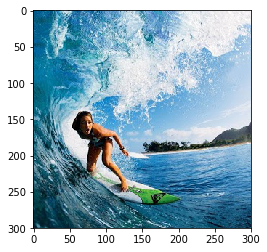

Match 0.728736304328


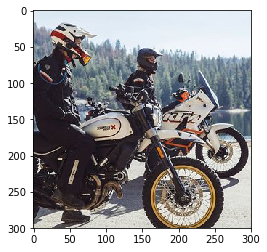

In [0]:
def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = 'resources/images/'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting 3 random images 
    sample = random.sample(files, 3)
    
    batch_extractor(images_path)

    ma = Matcher('features.pck')
    
    for s in sample:
        print 'Query image =========================================='
        show_img(s)
        names, match = ma.match(s, topn=3)
        print 'Result images ========================================'
        for i in range(3):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print 'Match %s' % (1-match[i])
            show_img(os.path.join(images_path, names[i]))

run()